In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import random
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip
from torch.utils.data import DataLoader
from torch import cuda

In [2]:
DIRECTORY = "./working/CIFAR10"
DEVICE = "cuda" if cuda.is_available() else "cpu"
print(DEVICE)

BATCH_SIZE = 256
NUM_CLASSES = 10
NUM_EPOCHS = 35

LEARNING_RATE = 0.002

cuda


In [3]:
def get_data_loader(directory, batch_size, train=True):
    """
    Returns a DataLoader for the CIFAR-10 dataset.
    Args:
        directory (str): Path to store dataset.
        batch_size (int): Number of samples per batch.
        train (bool): Whether to load the training set.
    """
    # Define transformation functions
    transform_list = [ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]

    if train:
        transform_list = [RandomCrop(32, padding=4), RandomHorizontalFlip()] + transform_list

    transform = Compose(transform_list)

    dataset = CIFAR10(root=directory, train=train, download=True, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=train, num_workers=2)


In [4]:
train_loader = get_data_loader(DIRECTORY, BATCH_SIZE, train=True)
test_loader = get_data_loader(DIRECTORY, BATCH_SIZE, train=False)


100%|██████████| 170M/170M [00:04<00:00, 42.2MB/s]


Extracting ./working/CIFAR10/cifar-10-python.tar.gz to ./working/CIFAR10
Files already downloaded and verified


In [5]:
print(f"Train data shape: {train_loader.dataset.data.shape}")
print(f"Test data shape: {test_loader.dataset.data.shape}")

Train data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


Отрисовка случайных изображений каждого класса

Classes of dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


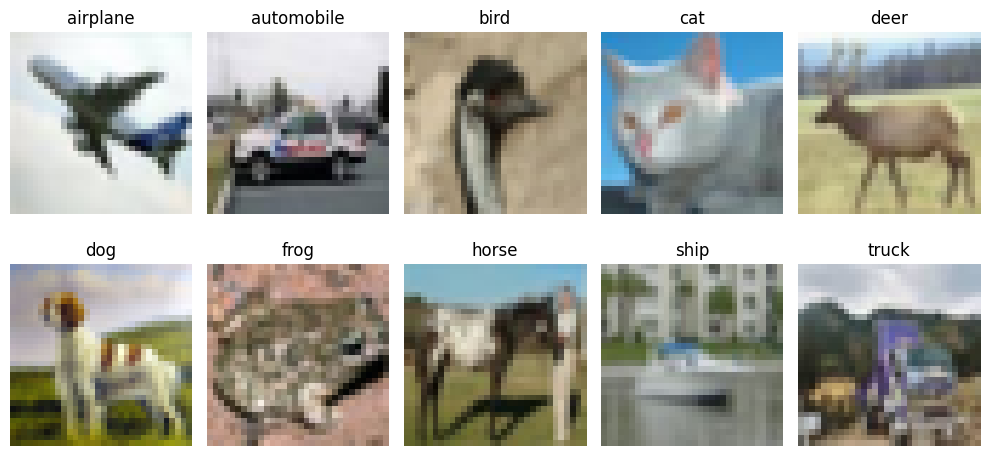

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f'Classes of dataset: {class_names}')

# Отрисовка случайных изображений каждого класса
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
r=0
for  idx, ax in enumerate(axes.flatten()):
    while (train_loader.dataset.classes[train_loader.dataset.targets[r]] != class_names[idx]):
        r = random.randint(1, 50000)
    sample_image = train_loader.dataset.data[r]

    label = train_loader.dataset.classes[train_loader.dataset.targets[r]]
    ax.imshow(sample_image, cmap=plt.cm.binary)
    ax.axis('off')
    ax.set_title(label)
plt.tight_layout()
plt.show()

In [48]:
def view_image(image, label, title):
    img = image.numpy().transpose(1, 2, 0)  # Преобразование в формат HxWxC
    img = img * 0.2023 + 0.4914  # Обратное нормирование (восстановление цветов)
    plt.imshow((img * 255).astype('uint8'))
    plt.title(f"{title}: {class_names[label]}")
    plt.axis('off')
    plt.show()

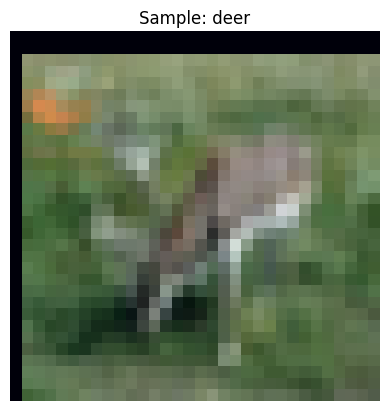

Label: 4


In [63]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
view_image(images[0], labels[0].item(), 'Sample')
print(f'Label: {labels[0].item()}')

In [9]:
print("Обучающая выборка: ")
print(f"Размер данных: {train_loader.dataset.data.shape}")
print(f"Количество меток: {len(train_loader.dataset.targets)}")

print("Тестовая выборка: ")
print(f"Размер данных: {test_loader.dataset.data.shape}")
print(f"Количество меток: {len(test_loader.dataset.targets)}")


Обучающая выборка: 
Размер данных: (50000, 32, 32, 3)
Количество меток: 50000
Тестовая выборка: 
Размер данных: (10000, 32, 32, 3)
Количество меток: 10000
True


Используем Архитектуру ResNet34

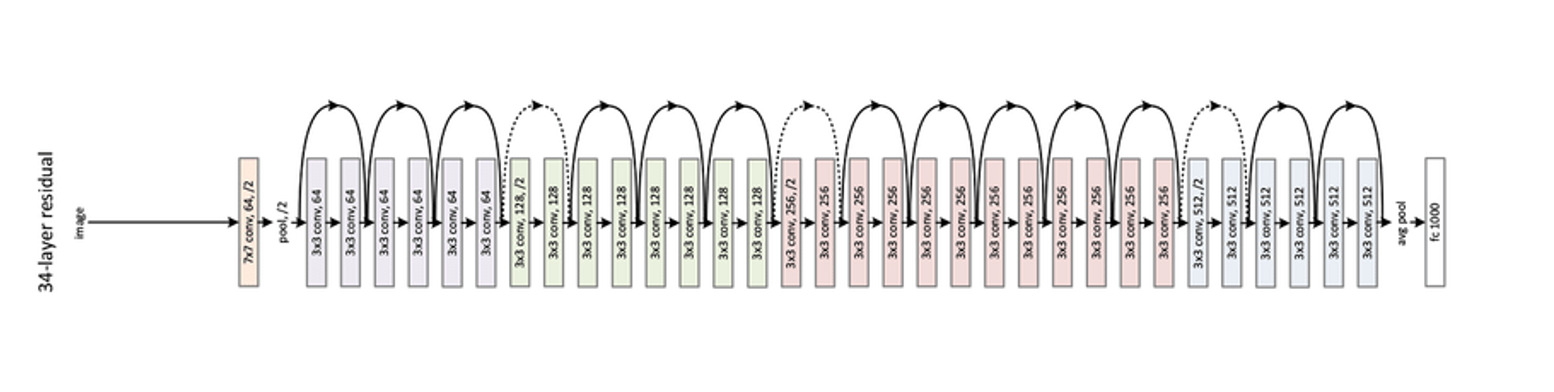

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)

        return out

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()

        self.in_channels = 64

        self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        print(strides)
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

def ResNet34():
    return ResNet(ResidualBlock, [3, 4, 6, 3])


In [13]:
model = ResNet34().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)


[1, 1, 1]
[2, 1, 1, 1]
[2, 1, 1, 1, 1, 1]
[2, 1, 1]


In [14]:
def train_model(model, train_loader, num_epochs):
    losses = []  # Store losses for each epoch
    accuracies = []  # Store accuracies for each epoch
    for epoch in range(num_epochs):
        model.train()
        epoch_loss, epoch_accuracy = [], []
        start_time = time.time()

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            epoch_accuracy.append((outputs.argmax(1) == targets).float().mean().item())

        epoch_loss_mean = np.mean(epoch_loss)
        epoch_accuracy_mean = np.mean(epoch_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss_mean:.4f}, Accuracy: {epoch_accuracy_mean:.4f}, Time: {time.time() - start_time:.2f}s")

        losses.append(epoch_loss_mean)
        accuracies.append(epoch_accuracy_mean)

    return losses, accuracies  # Return losses and accuracies for each epoch

Обучение модели

In [15]:
# Train the model
losses, accuracies = train_model(model, train_loader, NUM_EPOCHS)


Epoch 1/35, Loss: 1.6819, Accuracy: 0.3753, Time: 72.51s
Epoch 2/35, Loss: 1.2242, Accuracy: 0.5545, Time: 73.53s
Epoch 3/35, Loss: 0.9831, Accuracy: 0.6504, Time: 73.27s
Epoch 4/35, Loss: 0.8187, Accuracy: 0.7111, Time: 73.19s
Epoch 5/35, Loss: 0.7104, Accuracy: 0.7509, Time: 73.16s
Epoch 6/35, Loss: 0.6297, Accuracy: 0.7803, Time: 73.19s
Epoch 7/35, Loss: 0.5568, Accuracy: 0.8047, Time: 72.99s
Epoch 8/35, Loss: 0.5017, Accuracy: 0.8252, Time: 72.93s
Epoch 9/35, Loss: 0.4650, Accuracy: 0.8376, Time: 73.13s
Epoch 10/35, Loss: 0.4281, Accuracy: 0.8511, Time: 73.21s
Epoch 11/35, Loss: 0.3958, Accuracy: 0.8622, Time: 73.23s
Epoch 12/35, Loss: 0.3653, Accuracy: 0.8724, Time: 73.27s
Epoch 13/35, Loss: 0.3395, Accuracy: 0.8816, Time: 73.26s
Epoch 14/35, Loss: 0.3219, Accuracy: 0.8883, Time: 73.04s
Epoch 15/35, Loss: 0.2961, Accuracy: 0.8968, Time: 73.04s
Epoch 16/35, Loss: 0.2786, Accuracy: 0.9031, Time: 73.14s
Epoch 17/35, Loss: 0.2649, Accuracy: 0.9083, Time: 72.96s
Epoch 18/35, Loss: 0.24

In [17]:
torch.save(model.state_dict(), "resnet34.pth")
np.save("loss.npy", np.array(losses))
np.save("accuracy.npy", np.array(accuracies))


Результаты модели на тестовой выборке

In [18]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total, test_loss = 0, 0, 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            correct += (outputs.argmax(1) == targets).sum().item()
            total += targets.size(0)

    print(f"Test Loss: {test_loss / total:.5f}")
    print(f"Test Accuracy: {100. * correct / total:.2f}%")

In [19]:
evaluate_model(model, test_loader)

Test Loss: 0.00203
Test Accuracy: 87.28%
